In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import cv2
from tqdm import tqdm

In [2]:
# download data and unzip
url = 'https://gitlab.com/yuxuan.chen/'\
    'storage/-/blob/master/Deep-Learning-Examples/'\
    'fairface-img-margin025-trainval.zip'
data_dir = '../../storage/Deep-Learning-Examples/'
data_filename = 'fairface-img-margin025-trainval.zip'
data_path = data_dir + 'fairface-img-margin025-trainval/'

os.system('wget -nc {} -P {}'.format(url, data_dir))
if not os.path.exists(data_path):
    os.system('unzip {} -d {} > /dev/null'.format(
        data_dir + data_filename, data_dir))

train_df = pd.read_csv(
    data_path + 'fairface_label_train.csv').head(512)
val_df = pd.read_csv(
    data_path + 'fairface_label_val.csv').head(128)

# we notice age is given by inteval, here we assign exact values
def specify_age(age_str):
    if age_str == 'more than 70':
        return 75
    return int(age_str.split('-')[-1]) - 4
train_df['age'] = train_df['age'].apply(specify_age)
val_df['age'] = val_df['age'].apply(specify_age)
print(train_df.head())
print(val_df.head())

          file  age  gender        race  service_test
0  train/1.jpg   55    Male  East Asian          True
1  train/2.jpg   35  Female      Indian         False
2  train/3.jpg    5  Female       Black         False
3  train/4.jpg   25  Female      Indian          True
4  train/5.jpg   25  Female      Indian          True
        file  age  gender             race  service_test
0  val/1.jpg    5    Male       East Asian         False
1  val/2.jpg   55  Female       East Asian          True
2  val/3.jpg   35    Male            White          True
3  val/4.jpg   25  Female  Latino_Hispanic          True
4  val/5.jpg   25    Male  Southeast Asian         False


In [3]:
# hyper-parameters
num_epochs = 5
batch_size = 32
learning_rate = 0.002
weight_decay = 0
dropout = 0.4

# set device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [4]:
def df_to_numpy(df):
    images, labels = [], []
    for idx in tqdm(range(len(df))):
        row = df.iloc[idx].squeeze()
        file, age, gender = \
            row['file'], row['age'], bool(row['gender'] == 'Female')

        # get image and label
        image = cv2.imread(data_path + str(file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)      
        label = (int(age), int(gender))
        
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)


def preprocessing_fn(image, label):
    label = tf.cast(label, tf.float32)
    age, gender = label[0], label[1]
    age /= 75.

    # image normalization
    image = tf.cast(image, tf.float32)
    image /= 255.
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std
      
    return image, age, gender


train_x, train_y = df_to_numpy(train_df)
val_x, val_y = df_to_numpy(val_df)

# create dataloader
train_loader = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_loader = tf.data.Dataset.from_tensor_slices((val_x, val_y))
train_loader = train_loader.map(preprocessing_fn)
val_loader = val_loader.map(preprocessing_fn)

train_loader = train_loader.shuffle(
    buffer_size=train_x.shape[0], 
    reshuffle_each_iteration=True).batch(batch_size)
val_loader = val_loader.shuffle(
    buffer_size=val_x.shape[0], 
    reshuffle_each_iteration=False).batch(batch_size)
print(train_loader)
print(val_loader)

100%|██████████| 128/128 [00:01<00:00, 105.33it/s]
<BatchDataset shapes: ((None, 224, 224, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 224, 224, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.float32)>


In [5]:
# build model
class AgeGenderClassifier(keras.Model):
    def __init__(self, dropout=0):
        super(AgeGenderClassifier, self).__init__()

        self.intermediate = keras.Sequential([
                Dense(512, activation='relu'),
                Dropout(dropout),
                Dense(128, activation='relu'),
                Dropout(dropout),
                Dense(64, activation='relu')])

        self.age_classifier = Dense(1, activation='sigmoid')
        self.gender_classifier = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.intermediate(x)
        age = self.age_classifier(x)
        gender = self.gender_classifier(x)
        return age, gender


class VGG16(keras.Model):
    def __init__(self, dropout=0):
        super(VGG16, self).__init__()

        self.vgg = keras.Sequential()
        pre_trained_model = keras.applications.vgg16.VGG16()
        for layer in pre_trained_model.layers[:-4]:
            layer.trainable = False
            self.vgg.add(layer)
        
        self.new_conv = keras.Sequential([
            layers.Conv2D(filters=512, kernel_size=3),
            layers.MaxPool2D(pool_size=2, strides=2),
            Activation('relu'),
            layers.Flatten()])
        
        self.predictions = AgeGenderClassifier(dropout)

    def call(self, x):
        out = self.vgg(x)
        out = self.new_conv(out)
        out = self.predictions(out)
        return out

In [6]:
# set model, loss and optimizer
model = VGG16(dropout=dropout)
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
BCELoss = tf.keras.losses.BinaryCrossentropy()
L1Loss = tf.keras.losses.MeanAbsoluteError()

def accuracy(outputs, labels):
    hit = tf.equal(tf.argmax(outputs, 1), 
                   tf.cast(labels, tf.int64))
    return tf.reduce_mean(tf.cast(hit, tf.float32), axis=-1)

In [7]:
# train the model
for epoch in range(num_epochs):
    for images, ages, genders in train_loader:

        with tf.GradientTape() as g:
            # forward pass
            pred_ages, pred_genders = model(images, training=True)
            age_loss = L1Loss(ages, pred_ages)
            gender_loss = BCELoss(genders, pred_genders)
            l2_loss = weight_decay * tf.add_n(
                [tf.nn.l2_loss(v) for v in model.trainable_variables])
            loss = age_loss + gender_loss + l2_loss      
            gender_acc = accuracy(pred_genders, genders)
        
        # backward pass
        grad = g.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables))

    # report training loss and accuracy for the last batch 
    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(
        epoch + 1, num_epochs, loss.numpy()))
    print('Training Accuracy for Gender: {:.3f}%'.format(
            100 * gender_acc))
    print('Training Loss for Age: {:.4f}'.format(
            age_loss.numpy()))

    # validate after each epoch
    gender_accuracies = []
    for images, ages, genders in val_loader:
        pred_ages, pred_genders = model(images, training=False)
        gender_acc = accuracy(pred_genders, genders)
        age_loss = L1Loss(ages, pred_ages)
        gender_accuracies.append(gender_acc)
    print('Validation Accuracy for Gender: {:.3f}%'.format(
            100 * sum(gender_accuracies) / len(gender_accuracies)))
    print('Validation Loss for Age: {:.4f}'.format(
            age_loss.numpy()))
    print('=' * 50)

model.save_weights('./saved_model.ckpt', overwrite=True)

Epoch [1/5], Training Loss: 0.8889
Training Accuracy for Gender: 53.125%
Training Loss for Age: 0.1780
Validation Accuracy for Gender: 53.906%
Validation Loss for Age: 0.1933
Epoch [2/5], Training Loss: 0.8969
Training Accuracy for Gender: 59.375%
Training Loss for Age: 0.1980
Validation Accuracy for Gender: 53.906%
Validation Loss for Age: 0.1628
Epoch [3/5], Training Loss: 0.8401
Training Accuracy for Gender: 50.000%
Training Loss for Age: 0.1523
Validation Accuracy for Gender: 53.906%
Validation Loss for Age: 0.1566
Epoch [4/5], Training Loss: 0.6288
Training Accuracy for Gender: 56.250%
Training Loss for Age: 0.1402
Validation Accuracy for Gender: 53.906%
Validation Loss for Age: 0.1831
Epoch [5/5], Training Loss: 0.5857
Training Accuracy for Gender: 62.500%
Training Loss for Age: 0.1817
Validation Accuracy for Gender: 53.906%
Validation Loss for Age: 0.1702


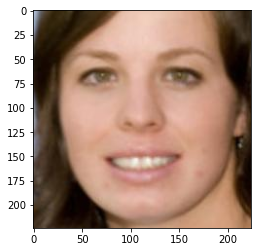

Predicted age: 27, predicted gender: Female


In [8]:
# read jpg and plot
file_path = data_path + 'val/516.jpg'#866
image = cv2.imread(file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# pre-processing
image = image.astype(np.float32) / 255.
image = (image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
image = np.expand_dims(image, axis=0)

# load the saved model
saved_model = VGG16(dropout=dropout)
saved_model.load_weights('./saved_model.ckpt')
pred_age, pred_gender = saved_model(image, training=False)
print('Predicted age: {}, predicted gender: {}'.format(
    int(pred_age.numpy() * 75), 
    'Female' if pred_gender.numpy() > 0.5 else 'Male'))